# Setup

In [ ]:
# Reviews CSV
%%capture
!wget https://www.dropbox.com/scl/fi/6u1yfcnnf4jqmhedx519u/Reviews.csv?rlkey=xqmvvohkq0i0k7hho79fs43b6&st=mexudbu2&dl=0
!mv Reviews.csv?rlkey=xqmvvohkq0i0k7hho79fs43b6 reviews.csv
# Metadata for each restaurant
!wget https://www.dropbox.com/scl/fi/cxckzuj81gsnlsvclqnza/metadata.json.gz?rlkey=d4xerrcwbeyt09oi01f9f4wru&st=sv6cnpzh&dl=0
!mv metadata.json.gz?rlkey=d4xerrcwbeyt09oi01f9f4wru metadata.json.gz

# Liberias

In [ ]:
# HuggingFace requirements
!pip install transformers datasets evaluate accelerate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 9.2 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [ ]:
!pip install nltk

In [ ]:
# HuggingFace
from transformers import T5ForConditionalGeneration, T5Tokenizer
import torch
# Data visualization and manipulation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Metadata
import gzip
import json

In [ ]:
# Evaluation
import copy
import nltk
nltk.download('punkt')
nltk.download('wordnet')
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from nltk import word_tokenize
from nltk.translate import meteor

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


## Data Preprocessing

In [ ]:
df = pd.read_csv('reviews.csv')
print(f"Tamaño dataset: {df.shape}")

# Eliminamos datos nulos ...
df = df.dropna()

Tamaño dataset: (8334, 7)


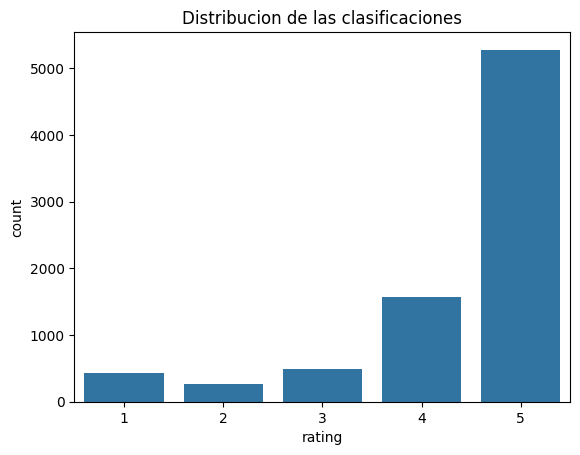

In [ ]:
# Revisamos distribución de ratings
sns.countplot(x='rating', data=df)
plt.title('Distribucion de las clasificaciones')
plt.show()

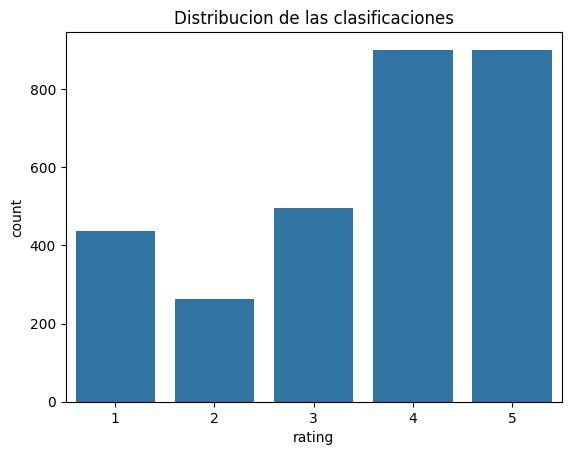

In [ ]:
# Reducimos cantidad maxima por rating para balancear distribucion
df = df.groupby('rating').head(900)
# Argupamos positivas >4 y negativas en <4
#df.loc[:, 'rating'] = df['rating'].apply(lambda x: 0 if x <= 3 else 1)
# volvemos a graficar
sns.countplot(x='rating', data=df)
plt.title('Distribucion de las clasificaciones')
plt.show()

In [ ]:
# Obtenemos el json de la metadata
def parse(path):
  g = gzip.open(path, 'r')
  for l in g:
    yield json.loads(l)

metadata = list(parse('metadata.json.gz'))
metadata = metadata[0]

In [ ]:
new_metadata = []
for value in metadata.values():
    new_metadata.extend(value)
idx2metadata = {}
for data in new_metadata:
    gmap_id = data['gmap_id']
    del data['gmap_id']
    idx2metadata[gmap_id] = data

## Review Generation


#### Flan T5

In [ ]:
def generate_review(user_id, item_id, rating, state, previous_reviews, model, tokenizer):
    """
    Genera una review a partir de uid, itid, state y una concatenación de previous reviews. Retorna la review generada.
    """
    prompt = f"Generate a detailed recommendation explanation for a restaurant based on the following details:\n"
    prompt += f"Expected Rating: {rating}\n"
    prompt += f"State: {state} (Mention how the location influences the dining experience)\n"
    prompt += f"Restaurant Information:\n"
    prompt += f"Name: {idx2metadata[item_id]['name']}\n"
    prompt += f"Description: {idx2metadata[item_id]['description']}\n"
    prompt += f"Category: {idx2metadata[item_id]['category']}\n"
    prompt += f"Average Rating: {idx2metadata[item_id]['avg_rating']}\n"
    prompt += f"Service Options: {idx2metadata[item_id]['MISC']['Service options']}\n"

    if previous_reviews:
        previous_reviews = previous_reviews.replace("\n", " - ")
        prompt += f"Previous Reviews from the user has made to restaurants with similar rating:\n* {previous_reviews}\n"

    prompt += f"Generate a very detailed recommendation explanation that reflects the customer's preferences and refers to the restaurant details. The tone should match the given rating (4 or 5 being the best). Review:"

    inputs = tokenizer(prompt, return_tensors="pt").input_ids
    outputs = model.generate(inputs, max_new_tokens=200)

    generated_review = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return generated_review.strip()

def generate_review_for_user_item_pair(user_id, item_id, df, model, tokenizer):
    """
    Recolecta hasta 3 reviews previas del usuario y genera una review a partir de uid y itid. Retorna la review generada.
    """
    # Par usuario-restaurante específico
    row = df[(df['user_id'] == user_id) & (df['gmap_id'] == item_id)]
    row = row.iloc[0]

    rating = row['rating']
    image_url = row['img_url']
    state = row['state']
    # Obtenemos reviews pasadas del usuario con ratings similares
    user_reviews = df[(df['user_id'] == user_id) & (df['rating'].isin([rating - 1, rating, rating + 1]))].head(3)
    # Eliminamos la review del restaurant objetivo
    user_reviews = user_reviews[user_reviews['gmap_id'] != item_id]
    previous_reviews = "\n* ".join(user_reviews['text'])
    context = previous_reviews

    return generate_review(user_id, item_id, rating, state, context, model, tokenizer)


In [ ]:
# Cargamos modelo flat T5 de huggingface
model_name = "google/flan-t5-large"
model_flan_t5 = T5ForConditionalGeneration.from_pretrained(model_name)
tokenizer_flan_t5 = T5Tokenizer.from_pretrained(model_name)
#tokenizer.pad_token = tokenizer.eos_token

config.json:   0%|          | 0.00/662 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.13G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
# Obtenemos row aleatoriamente
random_row = df.sample(1)
user_id = random_row['user_id'].values[0]
item_id = random_row['gmap_id'].values[0]

In [ ]:
print(idx2metadata[item_id])

{'name': "Papa John's Pizza", 'address': "Papa John's Pizza, 500 W Broad St, Falls Church, VA 22046", 'description': 'Take-out/delivery chain offering classic & specialty pizzas, wings & breadsticks, plus desserts.', 'latitude': 38.8867944, 'longitude': -77.1777599, 'category': ['Pizza restaurant'], 'avg_rating': 3.1, 'num_of_reviews': 105, 'price': '$', 'hours': [['Friday', '10AM–12AM'], ['Saturday', '10AM–12AM'], ['Sunday', '10AM–11PM'], ['Monday', '10AM–11PM'], ['Tuesday', '10AM–11PM'], ['Wednesday', '10AM–11PM'], ['Thursday', '10AM–11PM']], 'MISC': {'Service options': ['Curbside pickup', 'No-contact delivery', 'Delivery', 'Takeout', 'Dine-in'], 'Health & safety': ['Mask required', 'Staff wear masks'], 'Popular for': ['Lunch'], 'Accessibility': ['Wheelchair accessible entrance'], 'Offerings': ['Comfort food', 'Late-night food', 'Quick bite'], 'Dining options': ['Dessert'], 'Atmosphere': ['Casual']}, 'state': 'Open ⋅ Closes 12AM', 'relative_results': ['0x89b7b4c5ae132f8b:0x7b49344e6e

In [ ]:
# Generamos review
generated_review = generate_review_for_user_item_pair(user_id, item_id, df, model_flan_t5, tokenizer_flan_t5)
print(f"\n\nReview generada: \n{generated_review}")
print(f"\n\nReview real: \n{df[(df['user_id'] == user_id) & (df['gmap_id'] == item_id)]['text'].values[0]}")



Review generada: 
I've been to this restaurant several times and it's always been good. The food is always good and the service is always good.


Review real: 
Probably the best sandwich shop in the Foxhall/Georgetown area. While their creations aren't the cheapest (double Subway/Jimmy John's on Wisconsin), you can bet they'll be tasty. From vegetarian friendly options like their Brent Point and Sconset to their hearty and savory Dreamland and Nobadeer (recommended for Thanksgiving cravings), Jetties has a specialty for everybody. I have to knock their soups a little; I was pretty disappointed with the Maryland crab soup- the size was small, the crab scarce, and the soup a bit watery.  The sandwiches though, are second to none.




1.   Raffel, C., Shazeer, N., Roberts, A., Lee, K., Narang, S., Matena, M., ... & Liu, P. J. (2020). Exploring the limits of transfer learning with a unified text-to-text transformer. J. Mach. Learn. Res., 21(140), 1-67.
https://huggingface.co/google-t5/t5-base#uses




#### Bloomz-560m

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer

model_name = "bigscience/bloomz-560m"

tokenizer_bloom = AutoTokenizer.from_pretrained(model_name)
model_bloom = AutoModelForCausalLM.from_pretrained(model_name)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/222 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/14.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/715 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

In [ ]:
def generate_review_bloom(user_id, item_id, rating, state, previous_reviews, model, tokenizer):
    """
    Genera una review a partir de uid, itid, state y una concatenación de previous reviews. Retorna la review generada.
    """
    prompt = f"Generate a detailed recommendation explanation for a restaurant based on the following details:\n"
    prompt += f"Expected Rating: {rating}\n"
    prompt += f"State: {state} (Mention how the location influences the dining experience)\n"
    prompt += f"Restaurant Information:\n"
    prompt += f"Name: {idx2metadata[item_id]['name']}\n"
    prompt += f"Description: {idx2metadata[item_id]['description']}\n"
    prompt += f"Category: {idx2metadata[item_id]['category']}\n"
    prompt += f"Average Rating: {idx2metadata[item_id]['avg_rating']}\n"
    if 'MISC' in idx2metadata[item_id]:
      if 'Service options' in idx2metadata[item_id]['MISC']:
        prompt += f"Service Options: {idx2metadata[item_id]['MISC']['Service options']}\n"

    if previous_reviews:
        previous_reviews = previous_reviews.replace("\n", " - ")
        prompt += f"Previous Reviews from the user has made to restaurants with similar rating:\n* {previous_reviews}\n"

    prompt += f"Generate a very detailed recommendation explanation that reflects the customer's preferences and refers to the restaurant details. The tone should match the given rating (4 or 5 being the best). Review:"
    # https://huggingface.co/bigscience/bloomz-560m#citation
    inputs = tokenizer.encode(prompt, return_tensors="pt")
    outputs = model.generate(
        inputs,
        max_new_tokens=250,
        num_return_sequences=1,
        no_repeat_ngram_size=2,
        do_sample=True,
        top_k=50,
        top_p=0.95
    )
    return tokenizer.decode(outputs[0])[len(prompt) + 1: -4]



def generate_review_for_user_item_pair_bloom(user_id, item_id, df, model, tokenizer):
    """
    Recolecta hasta 3 reviews previas del usuario y genera una review a partir de uid y itid. Retorna la review generada.
    """
    # Par usuario-restaurante específico
    row = df[(df['user_id'] == user_id) & (df['gmap_id'] == item_id)]
    row = row.iloc[0]

    rating = row['rating']
    image_url = row['img_url']
    state = row['state']
    # Obtenemos reviews pasadas del usuario con ratings similares
    user_reviews = df[(df['user_id'] == user_id) & (df['rating'].isin([rating - 1, rating, rating + 1]))].head(3)
    # Eliminamos la review del restaurant objetivo
    user_reviews = user_reviews[user_reviews['gmap_id'] != item_id]
    previous_reviews = "\n* ".join(user_reviews['text'])
    context = previous_reviews

    return generate_review_bloom(user_id, item_id, rating, state, context, model, tokenizer)


In [ ]:
# Generamos review
generated_review = generate_review_for_user_item_pair_bloom(user_id, item_id, df, model_bloom, tokenizer_bloom)
print(f"\n\nReview generada: \n{generated_review}")
print(f"\n\nReview real: \n{df[(df['user_id'] == user_id) & (df['gmap_id'] == item_id)]['text'].values[0]}")



Review generada: 
The atmosphere is relaxing; the service is good and the food is of a high-quality; the staff are attentive and courteous. Highly recommend this restaurant.


Review real: 
Great food!


2. Niklas, M., Thomas, W., Lintang, S., Adam, R., Stella, B., Le Scao, T., Saiful Bari, M., Sheng, S., Zheng-Xin, Y., Hailey, S., Xiangru, T., Dragomir, R., Aji, A. F., Khalid, A., Samuel, A., Zaid, A., Albert, W., Edward, R., & Colin, R. (2022). Crosslingual Generalization through Multitask Finetuning. En arXiv [cs.CL]. http://arxiv.org/abs/2211.01786



# Evaluation


In [ ]:
# https://www.digitalocean.com/community/tutorials/automated-metrics-for-evaluating-generated-text
def calculate_bleu(candidate, reference):
    '''
    candidate, reference: generated and ground-truth sentences
    '''
    reference = word_tokenize(reference)
    candidate = word_tokenize(candidate)
    smoothing = SmoothingFunction().method1
    score = sentence_bleu([reference], candidate, smoothing_function=smoothing)
    return round(score, 4)

def calculate_meteor(candidate, reference):
  '''
  candidate, reference: tokenized list of words in the sentence
  '''
  reference = word_tokenize(reference)
  candidate = word_tokenize(candidate)
  meteor_score = round(meteor([candidate],reference), 4)
  return meteor_score

In [ ]:
# Buscamos review del user a ese item
user_reviews = df[(df['user_id'] == user_id) & (df['gmap_id'] == item_id)]
print(f"BLEU: {calculate_bleu(generated_review, user_reviews['text'].values[0])}")
print(f"METEOR: {calculate_meteor(generated_review, user_reviews['text'].values[0])}")

In [ ]:
# Generamos reviews para 100 pares de user id e item id de manera aleatoria y evaluamos
num_pairs = 10
bleu_scores = []
meteor_scores = []
for i in range(num_pairs):
    print(f"Generando {i}")
    random_row = df.sample(1)
    user_id = random_row['user_id'].values[0]
    item_id = random_row['gmap_id'].values[0]
    generated_review = generate_review_for_user_item_pair(user_id, item_id, df, model_)
    user_reviews = df[(df['user_id'] == user_id) & (df['gmap_id'] == item_id)]
    bleu_scores.append(calculate_bleu(generated_review, user_reviews['text'].values[0]))
    meteor_scores.append(calculate_meteor(generated_review, user_reviews['text'].values[0]))
print(f"BLEU promedio: {np.mean(bleu_scores)}")
print(f"METEOR promedio: {np.mean(meteor_scores)}")


In [ ]:
# Generamos reviews para 100 pares de user id e item id de manera aleatoria y evaluamos
num_pairs = 100
bleu_scores = []
meteor_scores = []
for i in range(num_pairs):
    print(f"Generando {i}")
    random_row = df.sample(1)
    user_id = random_row['user_id'].values[0]
    item_id = random_row['gmap_id'].values[0]
    generated_review = generate_review_for_user_item_pair_bloom(user_id, item_id, df, model_bloom, tokenizer_bloom)
    user_reviews = df[(df['user_id'] == user_id) & (df['gmap_id'] == item_id)]
    bleu_scores.append(calculate_bleu(generated_review, user_reviews['text'].values[0]))
    meteor_scores.append(calculate_meteor(generated_review, user_reviews['text'].values[0]))
    if i % 10 == 0:
      print(f"BLEU promedio: {np.mean(bleu_scores)}")
      print(f"METEOR promedio: {np.mean(meteor_scores)}")
print(f"BLEU promedio: {np.mean(bleu_scores)}")
print(f"METEOR promedio: {np.mean(meteor_scores)}")


Generando 0
BLEU promedio: 0.0013
METEOR promedio: 0.0143
Generando 1
Generando 2
Generando 3
Generando 4
Generando 5
Generando 6
Generando 7
Generando 8
Generando 9
Generando 10
BLEU promedio: 0.005181818181818182
METEOR promedio: 0.10823636363636364
Generando 11
Generando 12
Generando 13
Generando 14
Generando 15
Generando 16
Generando 17
Generando 18
Generando 19
Generando 20
BLEU promedio: 0.0037952380952380963
METEOR promedio: 0.08810476190476191
Generando 21
Generando 22
Generando 23
Generando 24
Generando 25
Generando 26
Generando 27
Generando 28
Generando 29
Generando 30
BLEU promedio: 0.003661290322580645
METEOR promedio: 0.08518387096774195
Generando 31
Generando 32
Generando 33
Generando 34
Generando 35
Generando 36
Generando 37
Generando 38
Generando 39
Generando 40
BLEU promedio: 0.0035853658536585363
METEOR promedio: 0.08816341463414634
Generando 41
Generando 42
Generando 43
Generando 44
Generando 45
Generando 46
Generando 47
Generando 48
Generando 49
Generando 50
BLEU pr